# EAST: An Efficient and Accurate Scene Text Detector

## Importing Libs

In [355]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

## Preprocessing 

In [356]:
detector = 'Sources/Models/frozen_east_text_detection.pb'
width, height = 320, 320
image = 'Sources/Images/cup.jpg'
min_confidence = 0.9

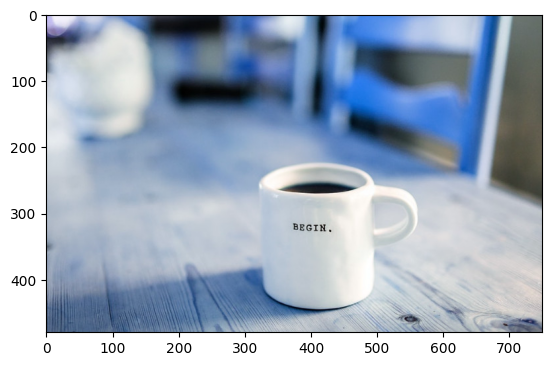

In [357]:
img = cv2.imread(image)
plt.imshow(img)
plt.show()

In [358]:
original = img.copy()
original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [359]:
img.shape

(480, 750, 3)

In [360]:
H, W = img.shape[0], img.shape[1]
print(H, W)

480 750


In [361]:
proportion_W = W / float(width)
proportion_H = H / float(height)
print(proportion_W, proportion_H)

2.34375 1.5


In [362]:
img = cv2.resize(img, (width, height))
H, W = img.shape[0], img.shape[1]
print(H, W)

320 320


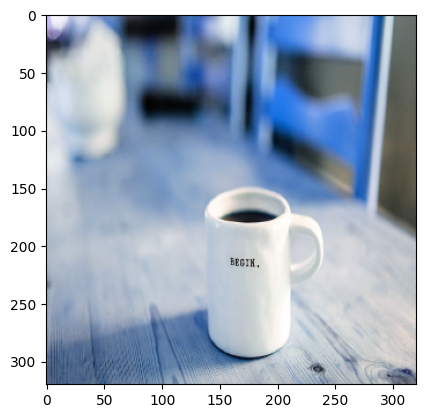

In [363]:
plt.imshow(img)
plt.show()

## Loading NN

In [364]:
layers_names = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']
neural_network = cv2.dnn.readNet(detector)

In [365]:
img.shape

(320, 320, 3)

In [366]:
blob = cv2.dnn.blobFromImage(img, 1.0,(W, H), swapRB=True, crop=False)
blob.shape  # B, C, H, W

(1, 3, 320, 320)

In [367]:
neural_network.setInput(blob)
scores, geometry = neural_network.forward(layers_names)
scores.shape, geometry.shape

((1, 1, 80, 80), (1, 5, 80, 80))

In [368]:
geometry[0, 0, 0]

array([154.84888 , 101.93866 , 108.211044, 110.352715, 111.57991 ,
       113.072105, 114.39853 , 116.14746 , 115.30821 , 115.90367 ,
       117.41572 , 118.78158 , 116.54512 , 116.345985, 121.443306,
       129.47731 , 137.60815 , 143.0237  , 146.83203 , 149.02911 ,
       149.08716 , 148.28293 , 147.12999 , 145.16942 , 143.07373 ,
       140.95235 , 138.77003 , 137.29414 , 134.19766 , 131.39839 ,
       129.34818 , 127.549515, 126.742744, 125.23266 , 120.422035,
       117.4272  , 116.22166 , 116.09964 , 116.904175, 118.21091 ,
       119.18678 , 123.20284 , 125.41774 , 126.38548 , 126.15488 ,
       126.19301 , 126.8588  , 126.928   , 128.21806 , 128.5202  ,
       128.97592 , 129.40462 , 130.30911 , 130.73264 , 130.80646 ,
       130.30139 , 129.3221  , 127.84737 , 126.378006, 125.06281 ,
       124.117935, 123.37592 , 122.265205, 120.858215, 120.00342 ,
       119.063965, 117.83419 , 116.99428 , 115.74401 , 117.560776,
       119.88267 , 121.39589 , 125.46845 , 121.879105, 120.994

In [369]:
scores.shape

(1, 1, 80, 80)

In [370]:
rows, columns = scores.shape[2:4]
print(rows, columns)

80 80


In [371]:
boxes= []
confidences = []

## Decoding Value

In [372]:
def geometric_data(geo, y):
    x_data_0 = geo[0, 0, y]
    x_data_1 = geo[0, 1, y]
    x_data_2 = geo[0, 2, y]
    x_data_3 = geo[0, 3, y]
    angles_data = geo[0, 4, y]
    return angles_data, x_data_0, x_data_1, x_data_2, x_data_3

In [373]:
def geometric_calculation(angles_data, x_data_0, x_data_1, x_data_2, x_data_3, x, y):
    (offset_x, offset_y) = (x * 4.0, y * 4.0)
    angle = angles_data[x]
    cos = np.cos(angle)
    sin = np.sin(angle)
    h = x_data_0[x] + x_data_2[x]
    w = x_data_1[x] + x_data_3[x]
    
    end_x = int(offset_x + (cos * x_data_1[x]) + (sin * x_data_2[x]))
    end_y = int(offset_y - (sin * x_data_1[x]) + (cos * x_data_2[x]))
    
    begin_x = int(end_x - w)
    begin_y = int(end_y - h)
    
    return begin_x, begin_y, end_x, end_y
    

In [374]:
scores

array([[[[1.47751834e-07, 5.33553248e-07, 6.18311901e-07, ...,
          2.38868756e-06, 2.14226091e-07, 1.97415238e-06],
         [2.21551218e-07, 8.22966868e-08, 1.52691939e-07, ...,
          3.80213396e-06, 2.49694665e-07, 2.09748373e-06],
         [2.41073451e-07, 2.56504393e-07, 6.74976263e-07, ...,
          4.48418587e-06, 6.08922051e-08, 2.51590927e-06],
         ...,
         [5.19032881e-07, 1.34708273e-07, 3.80787100e-08, ...,
          1.79544804e-06, 7.75350316e-07, 5.47007448e-06],
         [2.85668449e-07, 8.55808935e-08, 1.12900324e-07, ...,
          1.13548128e-06, 9.01576641e-07, 5.07822278e-06],
         [7.21997893e-08, 8.43337933e-09, 5.46041212e-09, ...,
          1.91420341e-07, 3.16596868e-07, 1.02403469e-07]]]],
      dtype=float32)

In [375]:
for y in range(0, rows):
    # print(y)
    data_scores = scores[0, 0, y]
    angles_data, x_data_0, x_data_1, x_data_2, x_data_3 = geometric_data(geometry, y)
    # print(angles_data, x_data_0, x_data_1, x_data_2, x_data_3 )
    for x in range(0, columns):
        if data_scores[x] < min_confidence:
            continue
            
        begin_x, begin_y, end_x, end_y = geometric_calculation(angles_data, x_data_0, x_data_1, x_data_2, x_data_3)
        confidences.append(float(data_scores[x]))
        boxes.append((begin_x, begin_y, end_x, end_y))
    

In [376]:
confidences

[0.9995617270469666,
 0.9998255372047424,
 0.999771773815155,
 0.9994677901268005,
 0.9662518501281738,
 0.9642106890678406,
 0.9993308782577515,
 0.9996801614761353,
 0.9995124340057373]

In [377]:
boxes

[(156, 208, 190, 220),
 (157, 208, 187, 220),
 (157, 208, 186, 220),
 (158, 207, 186, 220),
 (156, 207, 187, 221),
 (157, 207, 188, 220),
 (158, 208, 187, 221),
 (158, 208, 187, 221),
 (157, 208, 188, 221)]

In [378]:
detections = non_max_suppression(np.array(boxes), probs=confidences)

In [379]:
detections

array([[157, 208, 187, 220]])

<function matplotlib.pyplot.show(close=None, block=None)>

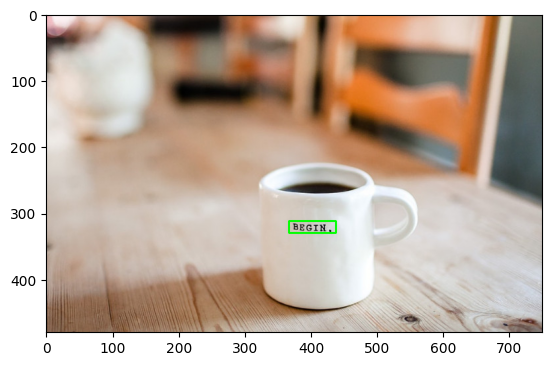

In [380]:
rgb_copy = original_rgb.copy()
roi_copy = original_rgb.copy()
for (begin_x, begin_y, end_x, end_y) in detections:
    # print(begin_x, begin_y, end_x, end_y)
    begin_x = int(begin_x * proportion_W)
    begin_y = int (begin_y * proportion_H)
    end_x = int(end_x * proportion_W)
    end_y = int(end_y * proportion_H)
    
    roi = roi_copy[begin_y:end_y, begin_x:end_x]
    
    cv2.rectangle(rgb_copy, (begin_x, begin_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(rgb_copy)
plt.show

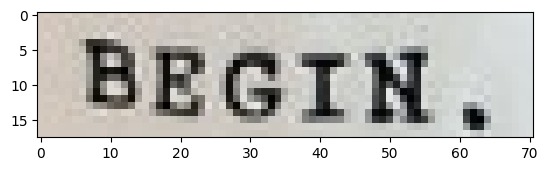

In [381]:
plt.imshow(roi)
plt.show()

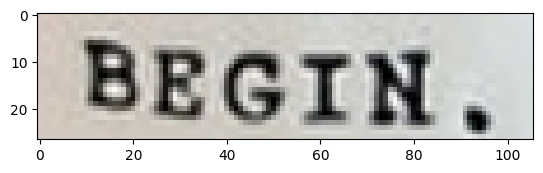

In [382]:
roi = cv2.resize(roi, None, fx = 1.5, fy = 1.5, interpolation = cv2.INTER_CUBIC)
plt.imshow(roi)
plt.show()

## Text recognition

In [383]:
import pytesseract

!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


BEGIN.


<function matplotlib.pyplot.show(close=None, block=None)>

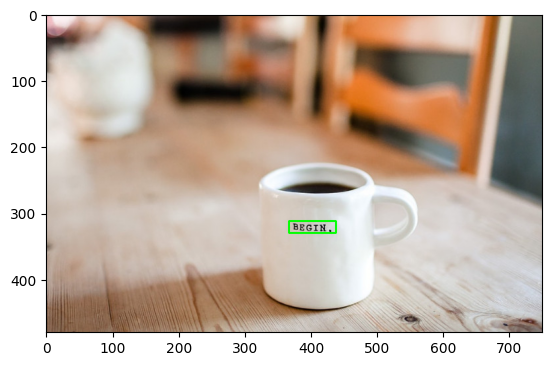

In [384]:
config_tesseract = "--tessdata-dir tessdata --psm 7"

rgb_copy = original_rgb.copy()
for (begin_x, begin_y, end_x, end_y) in detections:
    # print(begin_x, begin_y, end_x, end_y)
    begin_x = int(begin_x * proportion_W)
    begin_y = int (begin_y * proportion_H)
    end_x = int(end_x * proportion_W)
    end_y = int(end_y * proportion_H)
    
    roi = rgb_copy[begin_y:end_y, begin_x:end_x]
    text = pytesseract.image_to_string(roi, lang = 'eng', config=config_tesseract)
    print(text)
    
    cv2.rectangle(rgb_copy, (begin_x, begin_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(rgb_copy)
plt.show

## Expanding ROI

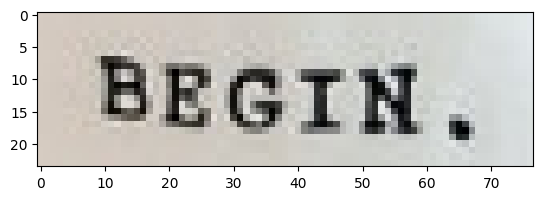

BEGIN.


In [387]:
margin = 3
rgb_copy = original_rgb.copy()
for (begin_x, begin_y, end_x, end_y) in detections:
    # print(begin_x, begin_y, end_x, end_y)
    begin_x = int(begin_x * proportion_W)
    begin_y = int (begin_y * proportion_H)
    end_x = int(end_x * proportion_W)
    end_y = int(end_y * proportion_H)
    
    roi = rgb_copy[begin_y-margin:end_y+margin, begin_x-margin:end_x+margin]
    plt.imshow(roi)
    plt.show()
    text = pytesseract.image_to_string(roi, lang = 'eng', config=config_tesseract)
    print(text)
    
    cv2.rectangle(rgb_copy, (begin_x-margin, begin_y-margin), (end_x+margin, end_y+margin), (0, 255, 0), 2)
    



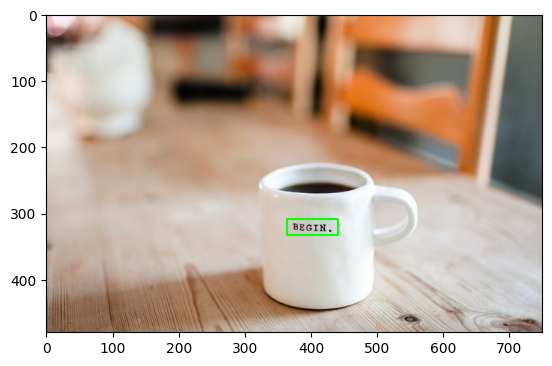

In [388]:
plt.imshow(rgb_copy)
plt.show()